In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

df = pd.read_csv('data/raw/Bank Customer Churn Prediction.csv')

df_clean = df.drop('customer_id', axis=1)

df_clean.shape

(10000, 11)

### Encode Categorical Variables

In [3]:
df_encoded = df_clean.copy()

# Binary encoding for gender (Male=1, Female=0)
print("\nEncoding gender:")
print(f"Original values: {df_encoded['gender'].unique()}")
df_encoded['gender'] = df_encoded['gender'].map({'Male': 1, 'Female': 0})
print(f"Encoded values: {df_encoded['gender'].unique()}")

# One-hot encoding for country (creates dummy variables)
print("\nEncoding country with One-Hot Encoding:")
print(f"Original values: {df_encoded['country'].unique()}")

# Dummy variables and drop first to avoid multicollinearity
country_dummies = pd.get_dummies(df_encoded['country'], prefix='country', drop_first=True)
print(f"Created columns: {country_dummies.columns.tolist()}")

# Concatenate with main dataframe and drop original country column
df_encoded = pd.concat([df_encoded, country_dummies], axis=1)
df_encoded = df_encoded.drop('country', axis=1)

print(f"\nShape after encoding: {df_encoded.shape}")
print(f"Columns after encoding: {df_encoded.columns.tolist()}")

df_encoded.head()


Encoding gender:
Original values: ['Female' 'Male']
Encoded values: [0 1]

Encoding country with One-Hot Encoding:
Original values: ['France' 'Spain' 'Germany']
Created columns: ['country_Germany', 'country_Spain']

Shape after encoding: (10000, 12)
Columns after encoding: ['credit_score', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn', 'country_Germany', 'country_Spain']


,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


Feature Engineering: We created new indicators like 'balance_per_product' and 'tenure_age_ratio' to capture non-linear relationships that might drive a customer's decision to leave

### Feature Engineering

In [4]:
# 1. Has Balance (binary feature)
# Many customers have 0 balance - this could be a strong predictor
df_encoded['has_balance'] = (df_encoded['balance'] > 0).astype(int)
print(f"\nCreated 'has_balance': {df_encoded['has_balance'].value_counts().to_dict()}")

# 2. Age groups (based on EDA showing age correlation with churn)
# Young: <30, Middle: 30-50, Senior: >50
df_encoded['age_group'] = pd.cut(df_encoded['age'], 
                                  bins=[0, 30, 50, 100], 
                                  labels=[0, 1, 2])
df_encoded['age_group'] = df_encoded['age_group'].astype(int)
print(f"Created 'age_group': {df_encoded['age_group'].value_counts().sort_index().to_dict()}")

# 3. Balance per product (interaction feature)
# Customers with high balance but few products might behave differently
df_encoded['balance_per_product'] = df_encoded['balance'] / (df_encoded['products_number'] + 1e-5)
print(f"\nCreated 'balance_per_product' (mean={df_encoded['balance_per_product'].mean():.2f})")

# 4. Tenure to Age ratio
df_encoded['tenure_age_ratio'] = df_encoded['tenure'] / (df_encoded['age'] + 1e-5)
print(f"Created 'tenure_age_ratio' (mean={df_encoded['tenure_age_ratio'].mean():.4f})")

print(f"\nFinal shape after feature engineering: {df_encoded.shape}")
print(f"All features: {df_encoded.columns.tolist()}")


Created 'has_balance': {1: 6383, 0: 3617}
Created 'age_group': {0: 1968, 1: 6771, 2: 1261}

Created 'balance_per_product' (mean=62819.14)
Created 'tenure_age_ratio' (mean=0.1379)

Final shape after feature engineering: (10000, 16)
All features: ['credit_score', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn', 'country_Germany', 'country_Spain', 'has_balance', 'age_group', 'balance_per_product', 'tenure_age_ratio']


### Separate Features and Target

In [5]:
# Separate X (features) and y (target)
X = df_encoded.drop('churn', axis=1)
y = df_encoded['churn']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nTarget distribution:\n{y.value_counts()}")
print(f"Target distribution (%):\n{y.value_counts(normalize=True) * 100}")

Features (X) shape: (10000, 15)
Target (y) shape: (10000,)

Target distribution:
churn
0    7963
1    2037
Name: count, dtype: int64
Target distribution (%):
churn
0    79.63
1    20.37
Name: proportion, dtype: float64


### Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print("  Will be used for cross-validation training")
print(f"Test set (HOLDOUT): X_test {X_test.shape}, y_test {y_test.shape}")
print("  Will be used ONLY for final model evaluation")

print(f"\nTrain target distribution:\n{y_train.value_counts()}")
print(f"Train target distribution (%):\n{y_train.value_counts(normalize=True) * 100}")

print(f"\nTest target distribution:\n{y_test.value_counts()}")
print(f"Test target distribution (%):\n{y_test.value_counts(normalize=True) * 100}")

Training set: X_train (8000, 15), y_train (8000,)
  Will be used for cross-validation training
Test set (HOLDOUT): X_test (2000, 15), y_test (2000,)
  Will be used ONLY for final model evaluation

Train target distribution:
churn
0    6370
1    1630
Name: count, dtype: int64
Train target distribution (%):
churn
0    79.625
1    20.375
Name: proportion, dtype: float64

Test target distribution:
churn
0    1593
1     407
Name: count, dtype: int64
Test target distribution (%):
churn
0    79.65
1    20.35
Name: proportion, dtype: float64


### Feature Scaling

Preprocessing Strategy: We use StandardScaler because distance-based models (like KNN/SVM) and Logistic Regression are sensitive to the scale of features. SMOTE will be used to balance the training set

In [7]:
# Standardize numerical features
# Fit only on training data to avoid data leakage
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled using StandardScaler")
print(f"\nScaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")

# Statistics of scaled features
print("\nScaled features statistics (sample):")
print(X_train_scaled.describe().iloc[:, :5])

Features scaled using StandardScaler

Scaled training data shape: (8000, 15)
Scaled test data shape: (2000, 15)

Scaled features statistics (sample):
       credit_score        gender           age        tenure       balance
count  8.000000e+03  8.000000e+03  8.000000e+03  8.000000e+03  8.000000e+03
mean  -5.728751e-16  7.105427e-17  2.486900e-16 -9.814372e-17  5.773160e-17
std    1.000063e+00  1.000063e+00  1.000063e+00  1.000063e+00  1.000063e+00
min   -3.113690e+00 -1.101919e+00 -1.989948e+00 -1.731895e+00 -1.226059e+00
25%   -6.910884e-01 -1.101919e+00 -6.599355e-01 -6.962018e-01 -1.226059e+00
50%    1.291536e-02  9.075074e-01 -1.849311e-01 -5.739468e-03  3.318547e-01
75%    6.858601e-01  9.075074e-01  4.800751e-01  1.029954e+00  8.226886e-01
max    2.062809e+00  9.075074e-01  5.040117e+00  1.720416e+00  2.600500e+00


### Handling Class Imbalance
SMOTE will be applied within the cross-validation loops in the modeling notebook to prevent data leakage between folds

Original training class distribution:
Class 0 (not churned): 6370
Class 1 (churned): 1630
Ratio: 3.91:1


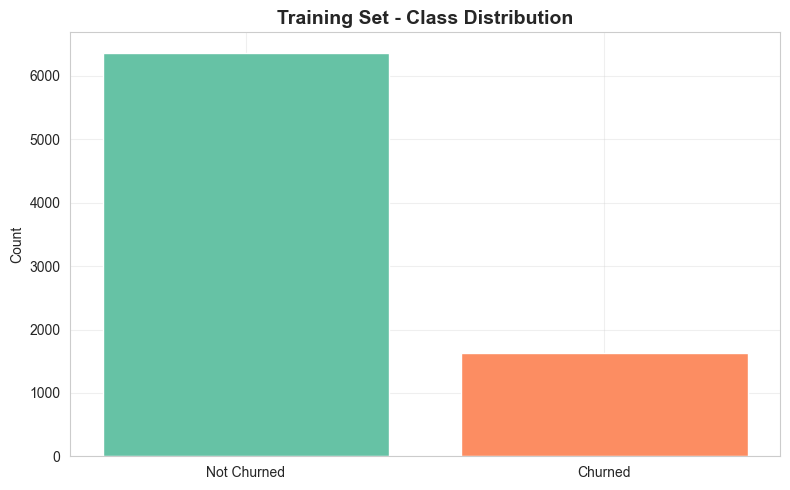

In [8]:
print("Original training class distribution:")
print(f"Class 0 (not churned): {(y_train == 0).sum()}")
print(f"Class 1 (churned): {(y_train == 1).sum()}")
print(f"Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Class distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.bar(['Not Churned', 'Churned'], 
       [(y_train == 0).sum(), (y_train == 1).sum()],
       color=['#66c2a5', '#fc8d62'])
ax.set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Count')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Save Processed Data

In [14]:
processed_dir = Path('data/processed')

X_train_scaled.to_csv(processed_dir / 'X_train_scaled.csv', index=False)
X_test_scaled.to_csv(processed_dir / 'X_test_scaled.csv', index=False)
y_train.to_csv(processed_dir / 'y_train.csv', index=False, header=['churn'])
y_test.to_csv(processed_dir / 'y_test.csv', index=False, header=['churn'])

### Summary:

Transformations Applied:
1. Dropped customer_id
2. Encoded gender (binary)
3. One-hot encoded country (France as reference)
4. Created 4 new features:
   - has_balance
   - age_group
   - balance_per_product
   - tenure_age_ratio
5. Scaled all features (StandardScaler)
6. Stratified train-test split (80/20)